In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow
import seaborn as sns
from sklearn.metrics import r2_score

from utils import *
from plot import *

In [5]:
def gen_Y_translate(X, labels, dim, kernel, translate_by=5, obs_noise=0.01):
    N = X.shape[0]
    Y = np.zeros([N, dim])
    
    label_counts = np.unique(labels, return_counts=True)[1]
    # fk(x), k=1
    Y[labels == 0, :] += np.random.default_rng().multivariate_normal(np.zeros(label_counts[0]), 
                                                                     kernel(X[labels == 0, :]), dim).T
    # fk(x), k=2
    delta = np.repeat([translate_by], dim)
    Y[labels == 1, :] += Y[labels == 0, :] + delta
    # add observational noise
    Y += np.random.normal(0, np.sqrt(obs_noise), Y.shape)
    return Y - Y.mean()

In [6]:
np.random.seed(1)

num_data = 200
dim = 5

xmin = -5
xmax = 5
break_pt = xmin + (xmax - xmin) * 0.6
k1 = 0.0
k21 = 0.5
k22 = -0.5
c1 = 0
sigma = 0.1
noise = 0.01

x = np.linspace(xmin, xmax, int(num_data/2), dtype=default_float())
X = branch_simulation(x, break_pt, k1, k21, k22, c1, sigma)
labels = np.repeat([0, 1], int(num_data)/2)
labels_dummy = pd.get_dummies(labels).values

kernel = gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2)
translate_by = 15
Y = gen_Y_translate(X, labels, dim, kernel, translate_by, noise)

In [7]:
np.random.seed(1)
M = 20
X_pca = PCA(n_components=2).fit_transform(Y)
#Z = np.random.permutation(X_pca)[:M, :]
Z = np.random.permutation(X)[:M]

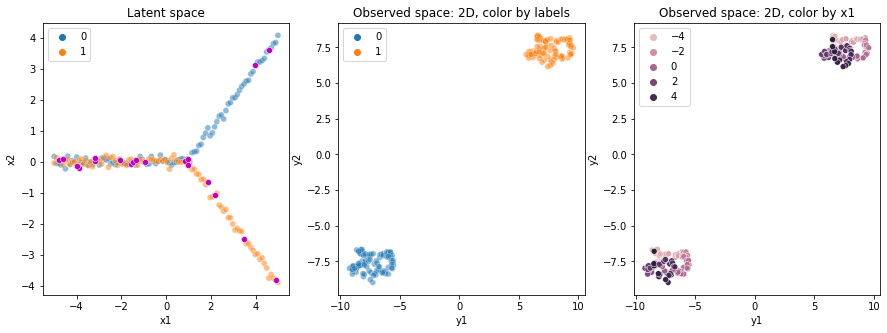

In [8]:
plot_Y(Y, X, labels, Z)

Text(0, 0.5, 'y1')

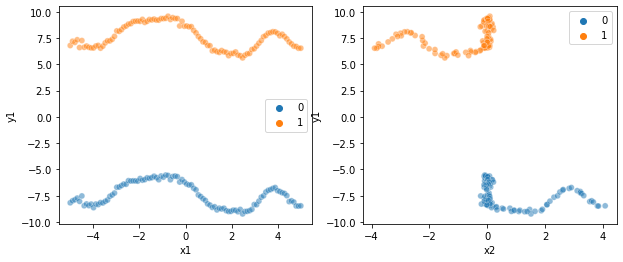

In [9]:
x1 = X[:, 0]
x2 = X[:, 1]
y1 = Y[:, 0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=x1, y=y1, hue=labels, alpha=0.5, ax=axs[0])
axs[0].set_xlabel('x1')
axs[0].set_ylabel('y1')
sns.scatterplot(x=x2, y=y1, hue=labels, alpha=0.5, ax=axs[1])
axs[1].set_xlabel('x2')
axs[1].set_ylabel('y1')

### Check ELBO correctness

In [7]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [62]:
m1 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    K=1,
    kernel_K=[
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2)
    ],
    Zp=Z,
    Xp_mean_init=X,
    Xp_var_init=np.full((num_data, 2), 1e-4)
)

models = [m1]
for m in models:
    set_trainable(m.Zp, False)
    set_trainable(m.kernel_K[0].variance, False)
    set_trainable(m.kernel_K[0].lengthscales, False)
    m.likelihood.variance.assign(0.01)
    set_trainable(m.likelihood.variance, False)
    set_trainable(m.Xp_mean, False)
    set_trainable(m.Xp_var, False)
    set_trainable(m.pi, False)

m2 = init_test_gplvm(
    Y=Y,
    latent_dim=2,
    kernel=gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
    inducing_variable=Z,
    X_mean_init=X,
    X_var_init=np.full((num_data, 2), 1e-4)
)
m2.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158521>

In [63]:
m2.elbo()

<tf.Tensor: shape=(), dtype=float64, numpy=-49973.85464359338>

In [64]:
elbo1, Fq1 = train_natgrad_adam(m1, 1, 1)

initial elbo -160059.0399
iteration 1 elbo -49973.8546, took 7.0494s


### Learn pi

In [306]:
def plot_mse(predY, Y):
    x = np.arange(1, num_data+1)
    y = predY
    ymax = 50
    for k in range(2):
        mse = tf.reduce_sum(tf.square(Y - predY[..., k]), axis=1)
        plt.scatter(x, mse, label='k={}'.format(k))
    plt.vlines(x=int(num_data * 0.5), ymin=0, ymax=ymax, color='r', label='switch branch')
    plt.vlines(x=int(num_data * 0.3), ymin=0, ymax=ymax, color='g', label='branch pt, k=0')
    plt.vlines(x=int(num_data * 0.8), ymin=0, ymax=ymax, color='g', label='branch pt, k=0')
    plt.xlabel('sample index')
    plt.ylabel('(Y - predY)^2')
    plt.legend()
    
def plot_qmu(m):
    for i in range(2):
        mu = m.q_mu[i].numpy()
        plt.scatter(mu[:, 0], mu[:, 1])

In [512]:
def plot_Fq(Fq, pi, num_data=200):
    x = np.arange(1, num_data+1)
    y = Fq
    plt.scatter(x, y[:, 0], label='k=1')
    plt.scatter(x, y[:, 1], label='k=2')
    Fq_pi = tf.reduce_sum(Fq * pi, axis=1)
    plt.scatter(x, Fq_pi, label='\sum_k pi_nk * Fnk', alpha=0.5)
    plt.vlines(x=int(num_data * 0.5), ymin=np.min(y), ymax=np.max(y), color='r', label='switch branch')
    plt.vlines(x=int(num_data * 0.3), ymin=np.min(y), ymax=np.max(y), color='m', label='branch pt, k=1')
    plt.vlines(x=int(num_data * 0.8), ymin=np.min(y), ymax=np.max(y), color='m', label='branch pt, k=2')
    plt.xlabel('sample index')
    plt.ylabel('Fnk')
    plt.legend()
    

def plot_Fq_list(Fq, num_data=200):
    idx = np.linspace(0, len(Fq)-1, 4, dtype=int)
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs = axs.flatten()

    for i in range(idx.size): 
        x = np.arange(1, num_data+1)
        y = Fq[idx[i]]
        axs[i].scatter(x, y[:, 0], label='k=1')
        axs[i].scatter(x, y[:, 1], label='k=2')
        axs[i].vlines(x=int(num_data * 0.5), ymin=y.min(), ymax=y.max(), color='r', label='switch branch')
        axs[i].vlines(x=int(num_data * 0.3), ymin=y.min(), ymax=y.max(), color='g', label='branch pt, k=1')
        axs[i].vlines(x=int(num_data * 0.8), ymin=y.min(), ymax=y.max(), color='g', label='branch pt, k=2')
        axs[i].set_xlabel('sample index')
        axs[i].set_ylabel('Fnk')
        axs[i].set_title('iteration {}'.format(idx[i]))
    plt.legend()
    plt.tight_layout()
    
def plot_assignment(m, Xmean):
    assignment = m.pi.numpy()[:, 0]
    sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=assignment)

In [519]:
# first compute the predicted observation by each of the K mixture: [N, D, K]
# then weight each mixture prediction by the mixture weight
# resulting in [N, D]
def get_pred_Y(m, by_K=False):
    pred_Y = np.zeros((m.N, m.D))
    if by_K:
        pred_Y_k = np.zeros((m.N, m.D, m.K))
    for k in range(m.K):
        kernel = m.kernel_K[k]
        Kmm = gpflow.covariances.Kuu(m.Zp, kernel, jitter=gpflow.default_jitter())
        Kmn = gpflow.covariances.Kuf(m.Zp, kernel, m.Xp_mean)
        pred = tf.transpose(Kmn) @ tf.linalg.inv(Kmm) @ m.q_mu[k]
        if by_K:
            pred_Y_k[..., k] = pred.numpy()
        assignment = m.pi.numpy()[:, k]
        pred_Y += pred.numpy() * np.stack([assignment for _ in range(m.D)], axis=1)
    if by_K:
        return pred_Y, pred_Y_k
    else:
        return pred_Y

def plot_pred_vs_true(Y_true, Y_pred, ax):
    ax.scatter(Y_true[:, 0], Y_true[:, 1], label='true')
    ax.scatter(Y_pred[:, 0], Y_pred[:, 1], label='pred', alpha=0.3)
    ax.legend()
    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_title('prediction vs. true, first 2D: R^2={:.4f}'.format(r2_score(Y_true, Y_pred)))
    
def plot_pred_true_1d(Y_true, Y_pred, dim, ax):
    ax.scatter(Y_true[:, dim], Y_pred[:, dim], alpha=0.3)
    ax.set_xlabel('true')
    ax.set_ylabel('pred')
    r2 = r2_score(Y_true[:, dim], Y_pred[:, dim])
    ax.set_title('prediction vs. true, dim={}: R^2={:.4f}'.format(dim, r2))
    
def plot_pred_by_K(Y_pred_k, ax):
    colors = ['r', 'g']
    for k in range(Y_pred_k.shape[-1]):
        pred = Y_pred_k[..., k]
        ax.scatter(pred[:, 0], pred[:, 1], color=colors[k], label='k={}'.format(k), alpha=0.3)
    ax.legend()
    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_title('prediction by mixture')

In [483]:
m11 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    K=2,
    kernel_K=[
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2)
    ],
    Zp=Z,
    Xp_mean_init=X,
    Xp_var_init=np.full((num_data, 2), 1e-4),
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float())
)

m12 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    K=2,
    kernel_K=[
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2)
    ],
    Zp=Z,
    Xp_mean_init=X,
    Xp_var_init=np.full((num_data, 2), 1e-4),
    pi_init=tf.constant(labels_dummy + 1e-6, dtype=default_float())
)
set_trainable(m12.pi, False)

models = [m11, m12]
for m in models:
    set_trainable(m.Zp, False)
    set_trainable(m.kernel_K[0].variance, False)
    set_trainable(m.kernel_K[1].variance, False)
    set_trainable(m.kernel_K[0].lengthscales, False)
    set_trainable(m.kernel_K[1].lengthscales, False)
    m.likelihood.variance.assign(0.01)
    set_trainable(m.likelihood.variance, False)
    set_trainable(m.Xp_mean, False)
    set_trainable(m.Xp_var, False)

When given the true X, the model w/ the correct pi has much better ELBO than the model w/ random pi. But given the way the likelihood looks, the model seems incapable of learning the correct pi when initialized randomly. It just get stuck in some local minima

In [485]:
%%time
elbo11, Fq11 = train_natgrad_adam(m11, 30000, 100)

initial elbo -4303100.8239
iteration 100 elbo -1308345.4786, took 0.0275s
iteration 200 elbo -777094.3462, took 0.0293s
iteration 300 elbo -540352.9380, took 0.0293s
iteration 400 elbo -439903.6903, took 0.0308s
iteration 500 elbo -389717.7231, took 0.0301s
iteration 600 elbo -361418.3074, took 0.0297s
iteration 700 elbo -343551.9281, took 0.0485s
iteration 800 elbo -331417.0256, took 0.0293s
iteration 900 elbo -322715.3216, took 0.0406s
iteration 1000 elbo -316218.3023, took 0.0313s
iteration 1100 elbo -311254.3904, took 0.0292s
iteration 1200 elbo -307361.9771, took 0.0286s
iteration 1300 elbo -304239.5120, took 0.0287s
iteration 1400 elbo -301690.0779, took 0.0300s
iteration 1500 elbo -299582.8344, took 0.0289s
iteration 1600 elbo -297815.8030, took 0.0297s
iteration 1700 elbo -296309.6118, took 0.0289s
iteration 1800 elbo -295021.1013, took 0.0305s
iteration 1900 elbo -293906.6417, took 0.0292s
iteration 2000 elbo -292943.9213, took 0.0300s
iteration 2100 elbo -292102.7711, took 0.

iteration 17400 elbo -283554.4071, took 0.0327s
iteration 17500 elbo -283554.3048, took 0.0318s
iteration 17600 elbo -283554.2074, took 0.0325s
iteration 17700 elbo -283554.1147, took 0.0298s
iteration 17800 elbo -283554.0266, took 0.0300s
iteration 17900 elbo -283553.9428, took 0.0447s
iteration 18000 elbo -283553.8630, took 0.0344s
iteration 18100 elbo -283553.7872, took 0.0322s
iteration 18200 elbo -283553.7150, took 0.0299s
iteration 18300 elbo -283553.6464, took 0.0309s
iteration 18400 elbo -283553.5810, took 0.0311s
iteration 18500 elbo -283553.5189, took 0.0307s
iteration 18600 elbo -283553.4598, took 0.0300s
iteration 18700 elbo -283553.4036, took 0.0302s
iteration 18800 elbo -283553.3501, took 0.0307s
iteration 18900 elbo -283553.2992, took 0.0315s
iteration 19000 elbo -283553.2508, took 0.0297s
iteration 19100 elbo -283553.2047, took 0.0314s
iteration 19200 elbo -283553.1609, took 0.0277s
iteration 19300 elbo -283553.1192, took 0.0304s
iteration 19400 elbo -283553.0796, took 

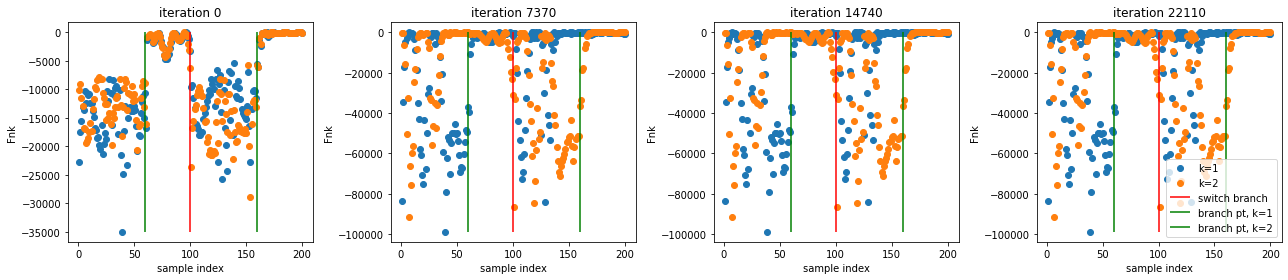

In [486]:
plot_Fq_list(Fq11, num_data)

Text(0.5, 1.0, 'Learn X, init random')

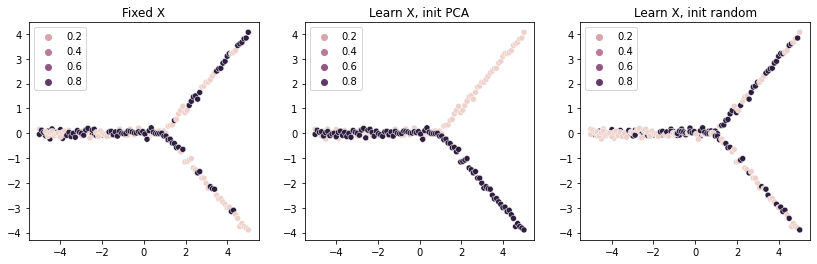

In [578]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plot_assignment(m11, X, axs[0])
plot_assignment(m1, X, axs[1])
plot_assignment(m3, X, axs[2])
axs[0].set_title('Fixed X')
axs[1].set_title('Learn X, init PCA')
axs[2].set_title('Learn X, init random')

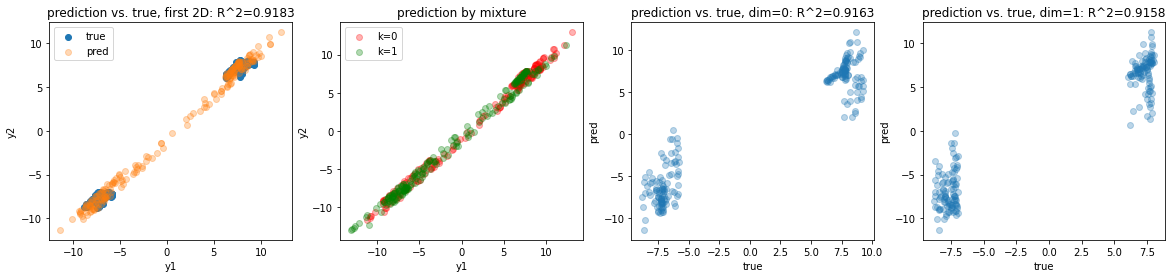

In [520]:
m11_pred, m11_pred_k = get_pred_Y(m11, True)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
plot_pred_vs_true(Y, m11_pred, axs[0])
plot_pred_by_K(m11_pred_k, axs[1])
plot_pred_true_1d(Y, m11_pred, 0, axs[2])
plot_pred_true_1d(Y, m11_pred, 1, axs[3])

Since the model couldn't find the right mixture here, both functions will try to explain points in both clusters, and to increase likelihood, the assignment will just pick out the predictions in the extremes, resulting in highly confident assignment, but they can be arbitarily different from the actual correct assignments. 

In [489]:
elbo12, Fq12 = train_natgrad_adam(m12, 100, 1)

initial elbo -4303220.9501
iteration 1 elbo -69968.0514, took 12.1500s
converge at iteration 2 elbo -69968.0514


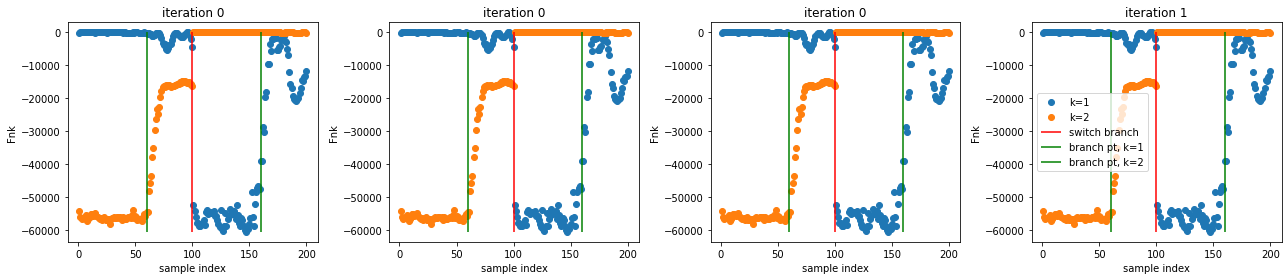

In [490]:
plot_Fq_list(Fq12, num_data)

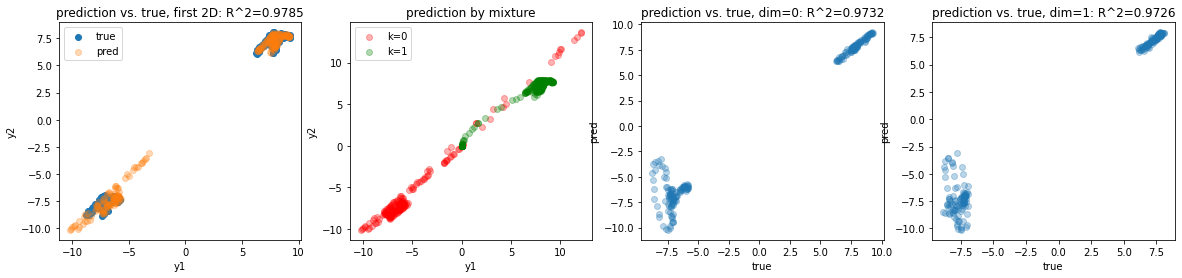

In [521]:
m12_pred, m12_pred_k = get_pred_Y(m12, True)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
plot_pred_vs_true(Y, m12_pred, axs[0])
plot_pred_by_K(m12_pred_k, axs[1])
plot_pred_true_1d(Y, m12_pred, 0, axs[2])
plot_pred_true_1d(Y, m12_pred, 1, axs[3])

In [22]:
def klu(m):
    KL_u = 0
    for k in range(2):
        prior_Kuu_k = gpflow.covariances.Kuu(m.Zp, m.kernel_K[k], jitter=gpflow.default_jitter())
        KL_u += gpflow.kullback_leiblers.gauss_kl(q_mu=m.q_mu[k], q_sqrt=m.q_sqrt[k], K=prior_Kuu_k)
    return KL_u

In [493]:
klu(m11)

<tf.Tensor: shape=(), dtype=float64, numpy=43649.976397175444>

In [494]:
klu(m12)

<tf.Tensor: shape=(), dtype=float64, numpy=2869.005419354902>

### Learn X, when given pi

In [29]:
# X init w/ pca, learn pi, fix hyperparams
m1 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    K=2,
    kernel_K=[
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2)
    ],
    Zp=Z,
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float())
)

In [24]:
# X init w/ pca, fix pi, fix hyperparams
m2 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    K=2,
    kernel_K=[
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2)
    ],
    Zp=Z,
    pi_init=tf.constant(labels_dummy + 1e-6, dtype=default_float())
)
set_trainable(m2.pi, False)

In [11]:
a = np.linspace(-4, 4, 20)
a1, a2 = np.meshgrid(a, a)
grid = np.stack([a1.flatten(), a2.flatten()], axis=1)
X_random_init = np.random.permutation(grid)[:num_data]

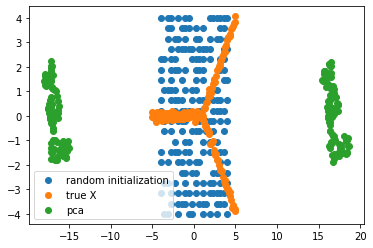

In [12]:
plt.scatter(X_random_init[:, 0], X_random_init[:, 1], label='random initialization')
plt.scatter(X[:, 0], X[:, 1], label='true X')
pca = PCA(2).fit_transform(Y)
plt.scatter(pca[:, 0], pca[:, 1], label='pca')
plt.legend()

In [13]:
# X init by randomly sample the space, learn pi, fix hyperparams
m3 = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    K=2,
    kernel_K=[
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2)
    ],
    Zp=Z,
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float()),
    Xp_mean_init=X_random_init
)

In [30]:
models = [m1]
for m in models:
    set_trainable(m.Zp, False)
    set_trainable(m.kernel_K[0].variance, False)
    set_trainable(m.kernel_K[1].variance, False)
    set_trainable(m.kernel_K[0].lengthscales, False)
    set_trainable(m.kernel_K[1].lengthscales, False)
    m.likelihood.variance.assign(0.01)
    set_trainable(m.likelihood.variance, False)
    #set_trainable(m.Xp_mean, False)
    #set_trainable(m.Xp_var, False)

In [496]:
gplvm = init_gplvm(
    Y=Y,
    latent_dim=2,
    kernel=gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
    inducing_variable=Z,
)
gplvm.likelihood.variance.assign(0.01)
set_trainable(gplvm.likelihood.variance, False)
set_trainable(gplvm.kernel.variance, False)
set_trainable(gplvm.kernel.lengthscales, False)
set_trainable(gplvm.inducing_variable, False)

In [497]:
_ = train_scipy(gplvm, 30000, True)

step 0 elbo: -339231.8911595539
step 1 elbo: -339219.38736052264
step 2 elbo: -338774.85588648
step 3 elbo: -338092.0627790151
step 4 elbo: -334983.813895195
step 5 elbo: -334185.10096811317
step 6 elbo: -333362.83386379573
step 7 elbo: -331935.14057121286
step 8 elbo: -329486.208261706
step 9 elbo: -324930.0675178289
step 10 elbo: -292641.95062841714
step 11 elbo: -261080.87541796794
step 12 elbo: -245052.0747169895
step 13 elbo: -237690.17452952222
step 14 elbo: -226600.52407277536
step 15 elbo: -210146.14171799578
step 16 elbo: -191438.82784284095
step 17 elbo: -185372.85540823455
step 18 elbo: -178443.91201183348
step 19 elbo: -170010.72553362572
step 20 elbo: -166378.53488228185
step 21 elbo: -161460.94544062347
step 22 elbo: -154902.4852246905
step 23 elbo: -146896.90288785737
step 24 elbo: -134504.1042798733
step 25 elbo: -121922.05586755497
step 26 elbo: -119338.59635794302
step 27 elbo: -115130.02047483645
step 28 elbo: -108238.3172615763
step 29 elbo: -100765.57639264381
step

step 241 elbo: -11118.503640460513
step 242 elbo: -11032.634262423931
step 243 elbo: -10949.749186282184
step 244 elbo: -10861.467059773095
step 245 elbo: -10778.693230916895
step 246 elbo: -10705.606429769849
step 247 elbo: -10635.55773473461
step 248 elbo: -10576.98269988654
step 249 elbo: -10505.756144141125
step 250 elbo: -10458.128964978583
step 251 elbo: -10411.032321986584
step 252 elbo: -10366.317286975851
step 253 elbo: -10316.11766738633
step 254 elbo: -10254.550172158186
step 255 elbo: -10178.991588849518
step 256 elbo: -10110.892814402865
step 257 elbo: -10052.017588780069
step 258 elbo: -9993.11221202443
step 259 elbo: -9934.8239022479
step 260 elbo: -9891.053863366895
step 261 elbo: -9838.689649222059
step 262 elbo: -9778.069205077267
step 263 elbo: -9715.799843794666
step 264 elbo: -9655.244187063125
step 265 elbo: -9602.200622295768
step 266 elbo: -9561.020265851723
step 267 elbo: -9506.022625290772
step 268 elbo: -9446.135250860352
step 269 elbo: -9398.14203923542
step

step 483 elbo: -4673.192372756965
step 484 elbo: -4659.716772988684
step 485 elbo: -4653.235627604367
step 486 elbo: -4643.301428352937
step 487 elbo: -4629.772425778775
step 488 elbo: -4623.61331973828
step 489 elbo: -4613.722247518301
step 490 elbo: -4611.148087679313
step 491 elbo: -4606.355966026953
step 492 elbo: -4599.376612226022
step 493 elbo: -4592.089903044942
step 494 elbo: -4581.12251343264
step 495 elbo: -4576.59393062244
step 496 elbo: -4569.085006330537
step 497 elbo: -4567.433029026172
step 498 elbo: -4564.481786580968
step 499 elbo: -4559.409498401318
step 500 elbo: -4554.632849136726
step 501 elbo: -4546.706094525822
step 502 elbo: -4539.666947256913
step 503 elbo: -4531.302160415528
step 504 elbo: -4521.042886769975
step 505 elbo: -4514.8365634428665
step 506 elbo: -4504.979079709363
step 507 elbo: -4500.06134463897
step 508 elbo: -4492.059802320477
step 509 elbo: -4489.273060260079
step 510 elbo: -4484.152913971371
step 511 elbo: -4480.966971349184
step 512 elbo: -4

step 724 elbo: -3546.9079042285184
step 725 elbo: -3546.189430580091
step 726 elbo: -3545.549919275596
step 727 elbo: -3544.943789025533
step 728 elbo: -3544.372593776467
step 729 elbo: -3543.78103505623
step 730 elbo: -3543.1809267682424
step 731 elbo: -3542.655719666892
step 732 elbo: -3542.060078767055
step 733 elbo: -3541.5353718294987
step 734 elbo: -3541.0707554710784
step 735 elbo: -3540.5968343020177
step 736 elbo: -3540.0895528845385
step 737 elbo: -3539.666608790329
step 738 elbo: -3539.2373985189643
step 739 elbo: -3538.8768644493694
step 740 elbo: -3538.514294927126
step 741 elbo: -3538.160261313016
step 742 elbo: -3537.8566855644
step 743 elbo: -3537.520604848354
step 744 elbo: -3537.171361228954
step 745 elbo: -3536.790571057817
step 746 elbo: -3536.433550942799
step 747 elbo: -3536.137621736852
step 748 elbo: -3535.803601579319
step 749 elbo: -3535.4950117680487
step 750 elbo: -3535.19191031674
step 751 elbo: -3534.862775822439
step 752 elbo: -3534.506323572001
step 753 

step 963 elbo: -3519.33224601013
step 964 elbo: -3519.3318982010687
step 965 elbo: -3519.3315562900007
step 966 elbo: -3519.331238243102
step 967 elbo: -3519.3309217531887
step 968 elbo: -3519.330646637849
step 969 elbo: -3519.330340355532
step 970 elbo: -3519.3300150282776
step 971 elbo: -3519.3296973765664
step 972 elbo: -3519.3293681880696
step 973 elbo: -3519.3290648563802
step 974 elbo: -3519.328757547305
step 975 elbo: -3519.328476364181
step 976 elbo: -3519.328220381197
step 977 elbo: -3519.327976779287
step 978 elbo: -3519.327739746528
step 979 elbo: -3519.3274663443663
step 980 elbo: -3519.327212835774
step 981 elbo: -3519.3269453924263
step 982 elbo: -3519.326723662917
step 983 elbo: -3519.3265085797584
step 984 elbo: -3519.3263162104727
step 985 elbo: -3519.326108162512
step 986 elbo: -3519.325874174079
step 987 elbo: -3519.3256671977097
step 988 elbo: -3519.3254616073204
step 989 elbo: -3519.325273290594
step 990 elbo: -3519.3250919076763
step 991 elbo: -3519.3248882305174


In [32]:
m1.pi.numpy()

array([[0.5127493 , 0.4872507 ],
       [0.42425457, 0.57574543],
       [0.3879031 , 0.6120969 ],
       [0.78997778, 0.21002222],
       [0.35305811, 0.64694189],
       [0.33759994, 0.66240006],
       [0.15986689, 0.84013311],
       [0.71953887, 0.28046113],
       [0.76097786, 0.23902214],
       [0.60955165, 0.39044835],
       [0.44049875, 0.55950125],
       [0.27737576, 0.72262424],
       [0.83965375, 0.16034625],
       [0.3275347 , 0.6724653 ],
       [0.83306891, 0.16693109],
       [0.13713052, 0.86286948],
       [0.70262779, 0.29737221],
       [0.53207474, 0.46792526],
       [0.48073332, 0.51926668],
       [0.84151711, 0.15848289],
       [0.56855631, 0.43144369],
       [0.44466239, 0.55533761],
       [0.64333018, 0.35666982],
       [0.32633993, 0.67366007],
       [0.48641184, 0.51358816],
       [0.26320646, 0.73679354],
       [0.73973279, 0.26026721],
       [0.56402482, 0.43597518],
       [0.90140936, 0.09859064],
       [0.27826879, 0.72173121],
       [0.

In [33]:
%%time
elbo1 = train_natgrad_adam(m1, 30000, 100)

initial elbo -3147096.5901
iteration 100 elbo -2917783.9320, took 0.0528s
iteration 200 elbo -2914818.0603, took 0.0512s
iteration 300 elbo -2912142.7716, took 0.0506s
iteration 400 elbo -2909719.6212, took 0.0576s
iteration 500 elbo -2813049.5345, took 0.0477s
iteration 600 elbo -2274520.4544, took 0.0485s
iteration 700 elbo -1691903.5760, took 0.0482s
iteration 800 elbo -792880.4210, took 0.0484s
iteration 900 elbo -252172.0248, took 0.0497s
iteration 1000 elbo -83540.5242, took 0.0670s
iteration 1100 elbo -47274.0405, took 0.0481s
iteration 1200 elbo -38817.1466, took 0.0487s
iteration 1300 elbo -33313.6353, took 0.1169s
iteration 1400 elbo -28228.1362, took 0.0747s
iteration 1500 elbo -24213.0927, took 0.0638s
iteration 1600 elbo -21317.0029, took 0.0484s
iteration 1700 elbo -19130.3798, took 0.0594s
iteration 1800 elbo -16840.5482, took 0.0698s
iteration 1900 elbo -14641.2116, took 0.0555s
iteration 2000 elbo -13207.6131, took 0.0522s
iteration 2100 elbo -12178.7701, took 0.0531s


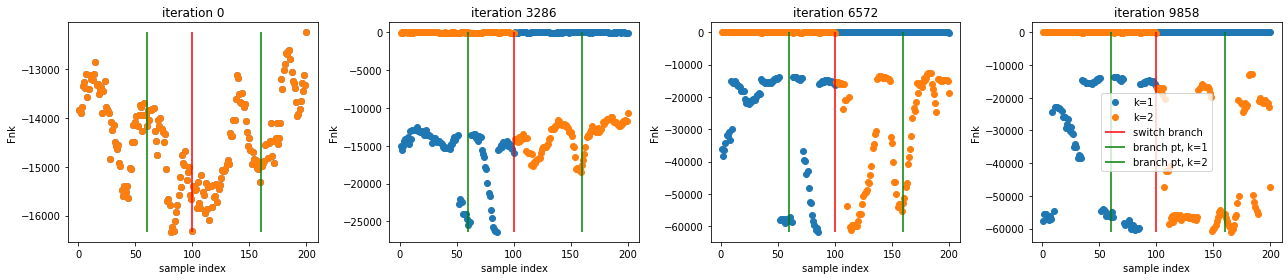

In [501]:
plot_Fq_list(Fq1, num_data)

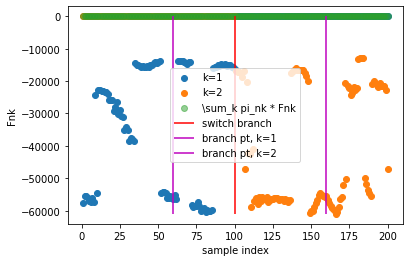

In [502]:
plot_Fq(Fq1[-1], m1.pi, num_data)

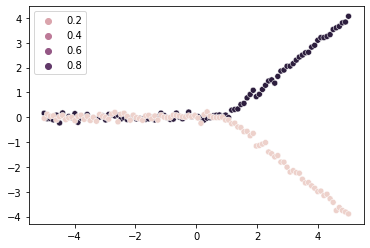

In [36]:
fig, ax = plt.subplots(1, 1)
plot_assignment(m1, X, ax)

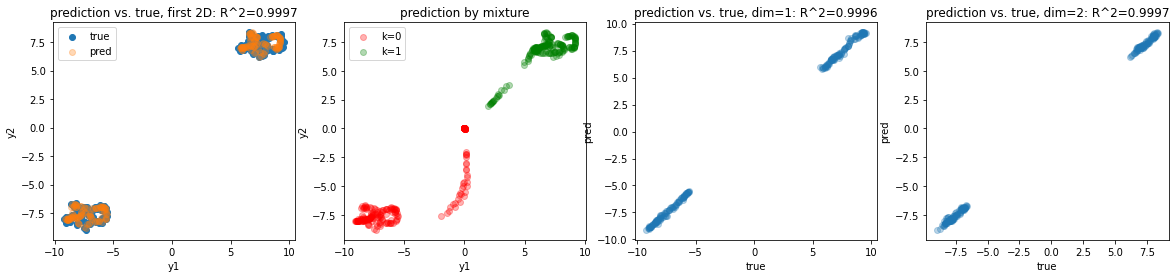

In [37]:
m1_pred, m1_pred_k = get_pred_Y(m1, True)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
plot_pred_vs_true(Y, m1_pred, axs[0])
plot_pred_by_K(m1_pred_k, axs[1])
plot_pred_true_1d(Y, m1_pred, 1, axs[2])
plot_pred_true_1d(Y, m1_pred, 2, axs[3])

In [38]:
klu(m1)

<tf.Tensor: shape=(), dtype=float64, numpy=1316.7915606477025>

For each mixture, for the points that don't belong to it, it tends to predict zeros, so the right plot below has many points concentrated around zero that aren't shown in the left plot

In [504]:
%%time
elbo2, Fq2 = train_natgrad_adam(m2, 30000, 100)

initial elbo -3141991.1037
iteration 100 elbo -2912727.2771, took 0.0442s
iteration 200 elbo -2909777.1971, took 0.0444s
iteration 300 elbo -2907104.7247, took 0.0441s
iteration 400 elbo -2904683.8887, took 0.0433s
iteration 500 elbo -2872966.2783, took 0.0424s
iteration 600 elbo -2302990.7092, took 0.0455s
iteration 700 elbo -1708008.8272, took 0.0425s
iteration 800 elbo -714644.2950, took 0.0520s
iteration 900 elbo -174312.9506, took 0.0440s
iteration 1000 elbo -59343.9240, took 0.0433s
iteration 1100 elbo -41893.5652, took 0.0475s
iteration 1200 elbo -35382.4255, took 0.0430s
iteration 1300 elbo -32294.3266, took 0.0420s
iteration 1400 elbo -29916.7093, took 0.0436s
iteration 1500 elbo -26694.3969, took 0.0433s
iteration 1600 elbo -23647.9297, took 0.0426s
iteration 1700 elbo -20725.2815, took 0.0429s
iteration 1800 elbo -17884.6690, took 0.0416s
iteration 1900 elbo -16245.6699, took 0.0441s
iteration 2000 elbo -15186.8756, took 0.0422s
iteration 2100 elbo -14336.4269, took 0.0462s


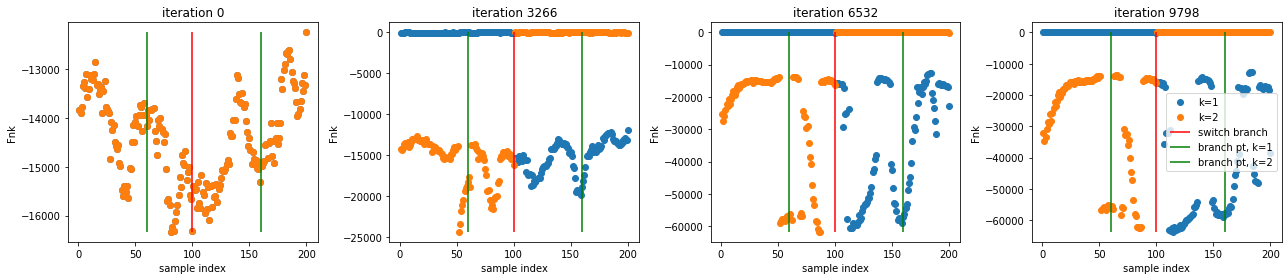

In [505]:
plot_Fq_list(Fq2, num_data)

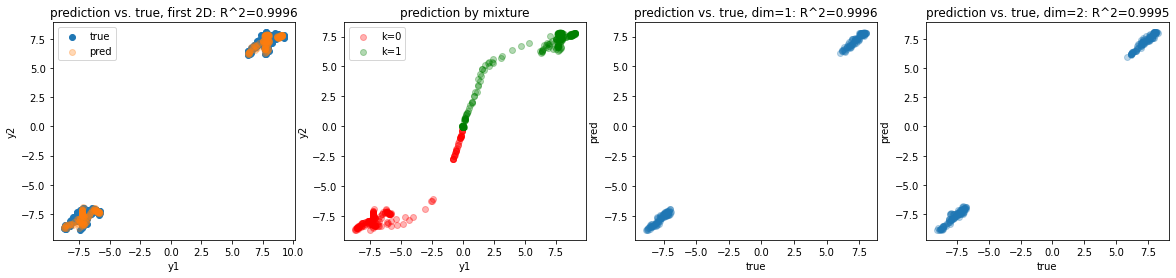

In [553]:
m2_pred, m2_pred_k = get_pred_Y(m2, True)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
plot_pred_vs_true(Y, m2_pred, axs[0])
plot_pred_by_K(m2_pred_k, axs[1])
plot_pred_true_1d(Y, m2_pred, 1, axs[2])
plot_pred_true_1d(Y, m2_pred, 2, axs[3])

In [507]:
klu(m1)

<tf.Tensor: shape=(), dtype=float64, numpy=1245.070676086741>

In [508]:
klu(m2)

<tf.Tensor: shape=(), dtype=float64, numpy=1292.4988183699866>

In [16]:
%%time
elbo3 = train_natgrad_adam(m3, 20000, 100)

initial elbo -20806127.2873
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
iteration 100 elbo -1316489.4383, took 0.0484s
iteration 200 elbo -541315.9738, took 0.0511s
iteration 300 elbo -288491.0819, took 0.0517s
iteration 400 elbo -209196.8277, took 0.0633s
iteration 500 elbo -181287.0092, took 0.0483s
iteration 600 elbo -166955.9362, took 0.0481s
iteration 700 elbo -158531.7339, took 0.0492s
iteration 800 elbo -153284.2474, took 0.0544s
iteration 900 elbo -149622.1138, took 0.0479s
iteration 1000 elbo -146694.4364, took 0.1326s
iteration 1100 elbo -144286.6014, took 0.0856s
iteration 1200 elbo -142254.2049, took 0.0483s
iteration 1300 elbo -140505.0122, took 0.0471s
iteration 1400 elbo -138974.6425, took 0.0465s
iteration 1500 elbo -137633.2852, took 0.0611s
iteration 1600 elbo -136464.0683, took 0.0466s
iteration 1700 elbo -135426.9663, took 0.0493s
iteration 1800 elbo -134444.9447, took 0.0548s
iteration 1900 e

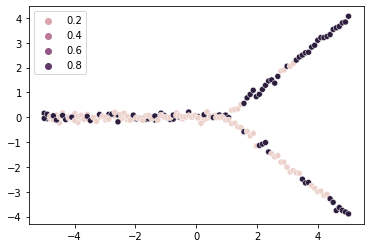

In [19]:
fig, ax = plt.subplots(1,1)
plot_assignment(m3, X, ax)

In [20]:
predm3, predKm3 = get_pred_Y(m3, True)

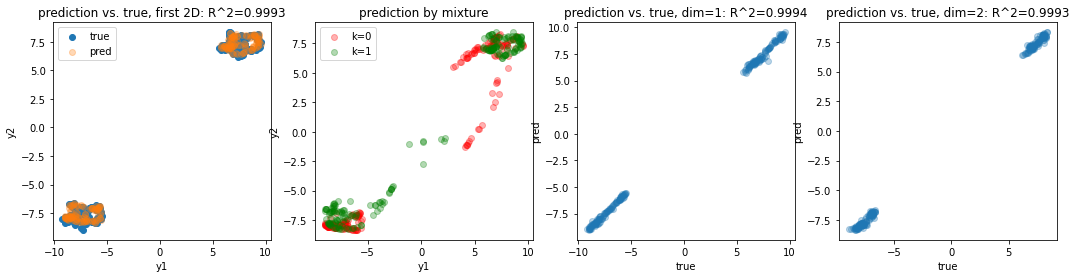

In [21]:
pred = predm3
predK = predKm3

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
plot_pred_vs_true(Y, pred, axs[0])
plot_pred_by_K(predK, axs[1])
plot_pred_true_1d(Y, pred, 1, axs[2])
plot_pred_true_1d(Y, pred, 2, axs[3])

In [23]:
klu(m3)

<tf.Tensor: shape=(), dtype=float64, numpy=2990.9255368471245>

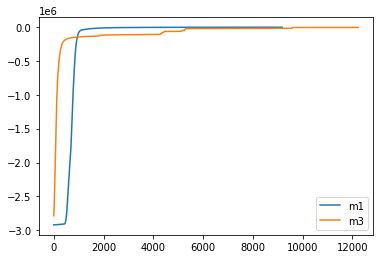

In [39]:
plt.plot(elbo1, label='m1')
plt.plot(elbo3, label='m3')
plt.legend()

<AxesSubplot:>

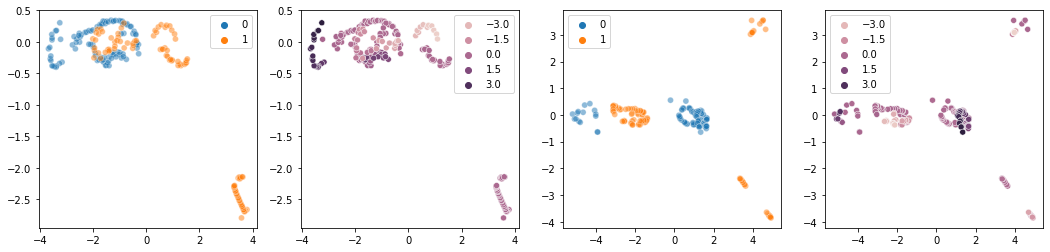

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

Xmean = m1.Xp_mean.numpy()
sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=labels, ax=axs[0], alpha=0.5)
sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=X[:, 1], ax=axs[1])

Xmean = m3.Xp_mean.numpy()
sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=labels, ax=axs[2], alpha=0.5)
sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=X[:, 1], ax=axs[3])

Same explaination as the model w/ fixed X and learn pi

In [570]:
m3

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.009999999999999998
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,False,(),float64,1.0
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,False,"(2,)",float64,[1. 1.]
SplitGPLVM.kernel_K[1].variance,Parameter,Softplus,,False,(),float64,1.0
SplitGPLVM.kernel_K[1].lengthscales,Parameter,Softplus,,False,"(2,)",float64,[1. 1.]
SplitGPLVM.Xp_mean,Parameter,,,True,"(200, 2)",float64,"[[3.49479827e+00, -2.51693871e+00..."
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(200, 2)",float64,"[[1.89066123e-04, 1.88981997e-04..."
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(200, 2)",float64,"[[5.49956802e-07, 9.99999450e-01..."
SplitGPLVM.Zp.Z,Parameter,,,False,"(20, 2)",float64,"[[8.58585859e-01, 2.85587325e-02..."
SplitGPLVM.q_mu[0],Parameter,,,False,"(20, 5)",float64,"[[7.66409049, 7.23356202, 7.89126859..."


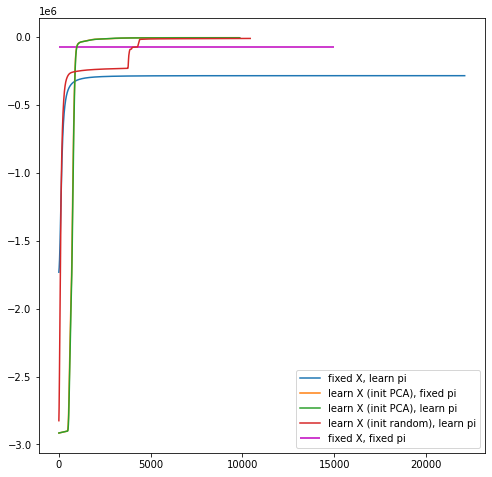

In [572]:
plt.figure(figsize=(8, 8))
names = [
    'fixed X, fixed pi',
    'fixed X, learn pi',
    'learn X (init PCA), fixed pi',
    'learn X (init PCA), learn pi',
    'learn X (init random), learn pi'
    
]

elbos = [elbo12, elbo11, elbo2, elbo1, elbo3]

for i, elbo in enumerate(elbos):
    if i == 0:
        plt.hlines(y=elbo[0], xmin=0, xmax=15000, color='m', label=names[i])
    else:
        plt.plot(elbo, label=names[i])
plt.legend()

When it comes to learning X, having the right mixture is no better than having a random mixture or no mixture at all. This is very weird, especially since Fnk looks as expected

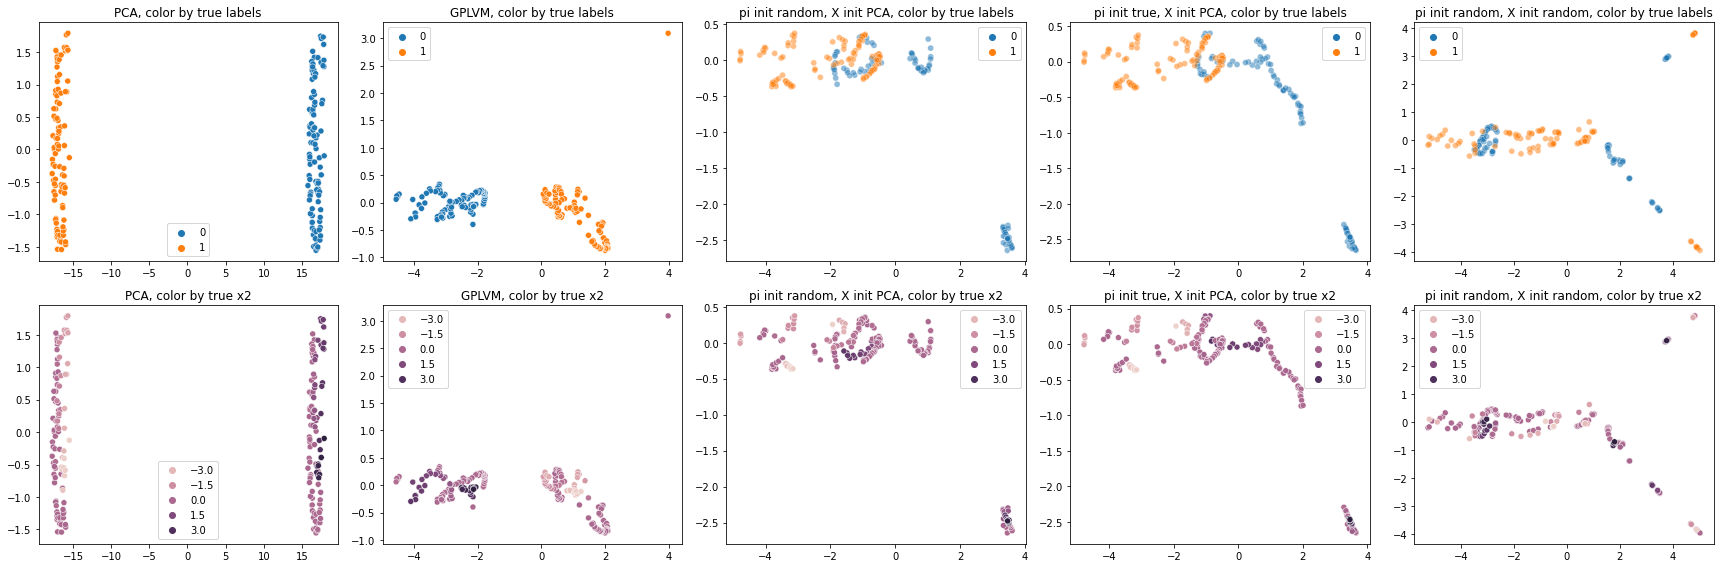

In [565]:
fig, axs = plt.subplots(2, 5, figsize=(24, 8))

names = [
    'PCA',
    'GPLVM',
    'pi init random, X init PCA',
    'pi init true, X init PCA',
    'pi init random, X init random'
]

X_pca = PCA(n_components=2).fit_transform(Y)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, ax=axs[0, 0])
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X[:, 1], ax=axs[1, 0])

Xmean = gplvm.X_data_mean.numpy()
sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=labels, ax=axs[0, 1])
sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=X[:, 1], ax=axs[1, 1])

models = [m1, m2, m3]
offset = 2
for i, m in enumerate(models):
    Xmean = m.Xp_mean.numpy()
    sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=labels, ax=axs[0, i+offset], alpha=0.5)
    sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=X[:, 1], ax=axs[1, i+offset])

for i, name in enumerate(names):
    axs[0, i].set_title('{}, color by true labels'.format(names[i]))
    axs[1, i].set_title('{}, color by true x2'.format(names[i]))

plt.tight_layout()

Because of the way the observations are generated, x1 is uninformative to the model, x2 is very informative to distinguish the mixture, so I think the x-axis in the latent embedding is actually trying to capture x2, you can see some gradient there, and that's why for most points the y-axis is zero, since the model is not using that dimension to explain the observations. (think of the model as having a seperate kernel working on each dimension under the hood)

That said, I don't know why some dark color blue points get mixed in the middle, and why there is a cluster of blue points w/ y = -2.5. I noticed that there is a stretch of blue points around x1 = 2.5 that don't have any inducing points placed on it. Also leads to the problem of Z, since here I'm using the true X to initialized them

### Play w/ optimization

In [104]:
m = init_split_gplvm(
    Y=Y,
    split_space=False,
    Qp=2,
    K=2,
    kernel_K=[
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
        gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2)
    ],
    Zp=Z,
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float()),
    Xp_mean_init=X,
    Xp_var_init=np.full((num_data, 2), 1e-4)
)
set_trainable(m.Zp, False)
m.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158521>

In [105]:
def get_trainable(params):
    return [p.unconstrained_variable for p in params]

num_iterations = 30000
log_freq = 100
log_elbo = []
tol = 1e-4

natgrad_steps = 1
qx_steps = 0
hyperparams_steps = 0
pi_steps = 5

natgrad_opt = NaturalGradient(gamma=1.0)
adam_opt = tf.optimizers.Adam(learning_rate=0.01)

hyperparams = [k.lengthscales for k in m.kernel_K] + [k.variance for k in m.kernel_K] + [m.likelihood.variance]
qx = [m.Xp_mean, m.Xp_var]

variational_params = list(zip(m.q_mu, m.q_sqrt))
gpflow.set_trainable(m.q_mu, False)
gpflow.set_trainable(m.q_sqrt, False)

@tf.function
def natgrad_step():
    natgrad_opt.minimize(m.training_loss, var_list=variational_params)

@tf.function
def pi_step():
    adam_opt.minimize(m.training_loss, var_list=get_trainable([m.pi]))

@tf.function
def qx_step():
    adam_opt.minimize(m.training_loss, var_list=get_trainable(qx))

@tf.function
def hyperparams_step():
    adam_opt.minimize(m.training_loss, var_list=get_trainable(hyperparams))

print('initial elbo {:.4f}'.format(m.elbo()))

for step in range(num_iterations):
    start_time = time.time()
    
    # update q(U)
    for _ in range(natgrad_steps):
        natgrad_step()
    # update q(c)
    for _ in range(pi_steps):
        pi_step()
    # update q(X)
    for _ in range(qx_steps):
        qx_step()
    # update hyperparams
    for _ in range(hyperparams_steps):
        hyperparams_step()
    
    elbo = m.elbo()
    log_elbo.append(elbo)

    if step > 0 and np.abs(elbo - log_elbo[-2]) < tol:
        print('converge at iteration {} elbo {:.4f}'.format(step+1, elbo))
        break
    if (step + 1)  % log_freq == 0:
        print('iteration {} elbo {:.4f}, took {:.4f}s'.format(step+1, elbo, time.time()-start_time))

initial elbo -169215.9026
iteration 100 elbo -13998.3870, took 0.0200s
iteration 200 elbo -12075.1388, took 0.0289s
iteration 300 elbo -11637.3067, took 0.0332s
iteration 400 elbo -11462.4680, took 0.0432s
iteration 500 elbo -11373.6892, took 0.0207s
iteration 600 elbo -11322.1187, took 0.0203s
iteration 700 elbo -11289.6417, took 0.0215s
iteration 800 elbo -11268.0735, took 0.0202s
iteration 900 elbo -11253.1862, took 0.0217s
iteration 1000 elbo -11242.6094, took 0.0222s
iteration 1100 elbo -11234.9302, took 0.0213s
iteration 1200 elbo -11229.2625, took 0.0212s
iteration 1300 elbo -11225.0270, took 0.0213s
iteration 1400 elbo -11221.8315, took 0.0220s
iteration 1500 elbo -11219.4030, took 0.0209s
iteration 1600 elbo -11217.5471, took 0.0206s
iteration 1700 elbo -11216.1224, took 0.0212s
iteration 1800 elbo -11215.0253, took 0.0205s
iteration 1900 elbo -11214.1781, took 0.0227s
iteration 2000 elbo -11213.5226, took 0.0218s
iteration 2100 elbo -11213.0146, took 0.0248s
iteration 2200 el

KeyboardInterrupt: 

<AxesSubplot:>

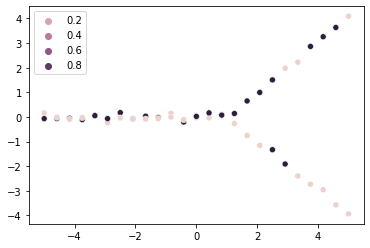

In [107]:
Xmean = m.Xp_mean.numpy()
sns.scatterplot(x=Xmean[:, 0], y=Xmean[:, 1], hue=m.pi.numpy()[:, 0])